[<font color='steelblue'>1. - __EDA__</font>](#one-bullet) <br>
    [<font color='steelblue'>1.1. - Imports</font>](#two-bullet) <br>
    [<font color='steelblue'>1.2. - Exploratory Data Analysis</font>](#three-bullet) <br>

[<font color='steelblue'>2. - __Genetic Algorithms__</font>](#four-bullet) <br>
    [<font color='steelblue'>2.1. - Defining Classes and Functions</font>](#five-bullet) <br>
    [<font color='steelblue'>2.2. - Genetic Operators</font>](#six-bullet) <br>
    [<font color='steelblue'>2.3. - Genetic Algorithms</font>](#seven-bullet) <br>
    [<font color='steelblue'>2.4. - Results</font>](#eight-bullet) <br>
    [<font color='steelblue'>2.5. - GridSearch of best model's parameters</font>](#nine-bullet) <br>

[<font color='steelblue'>3. - __GA vs Other Optimization Techniques__</font>](#ten-bullet) <br>
    [<font color='steelblue'>3.1. - Hill Climbing</font>](#eleven-bullet) <br>
    [<font color='steelblue'>3.2. - Simulated Annealing</font>](#twelve-bullet) <br>
    [<font color='steelblue'>3.3. - Comparison</font>](#thirteen-bullet) <br>

Group AU
|Name | Student ID |
|----|----|
|Joana Rodrigues| 20240603|
|Mara Simões| 20240326|
|Matilde Street| 20240523|
|Rafael Silva| 20240511|

<hr>
<a class="anchor" id="one-bullet">
<d style="color:white;">

# 1. EDA
</a>
</d>   

<a class="anchor" id="two-bullet">
<d style="color:white;">

## 1.1. Imports
</a>
</d>   

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### 1.1.1. Import Libraries

In [ ]:
from pathlib import Path
import pandas as pd
#from google.colab import drive
import numpy as np
import random
from copy import deepcopy
from typing import Callable
import math
import matplotlib.pyplot as plt
import itertools
from scipy.stats import ranksums
import seaborn as sns
from collections import Counter
import pickle
#from bayes_opt import BayesianOptimization

### 1.1.2. Import Dataset

In [4]:
path = 'seating_data.xlsx'
df = pd.read_excel(path)
df= df.set_index('idx')

print(df.head())

#drive.mount('/content/drive')
#df = pd.read_csv("seating_data(in).csv", index_col=0)

       1     2     3     4    5    6    7    8    9    10  ...   55   56  57  \
idx                                                        ...                 
1       0  5000     0     0  700  700    0    0    0    0  ...  100  100   0   
2    5000     0   700   700    0    0  300  300  500  500  ...  100  100   0   
3       0   700     0  2000    0    0    0    0  300  300  ...    0    0   0   
4       0   700  2000     0    0    0  900  400  300  300  ...    0    0   0   
5     700     0     0     0    0    0    0    0    0    0  ...    0    0   0   

      58   59   60   61  62  63  64  
idx                                  
1      0  100  100  100   0   0   0  
2    100    0    0    0   0   0   0  
3      0    0    0    0   0   0   0  
4      0    0    0    0   0   0   0  
5      0    0    0    0   0   0   0  

[5 rows x 64 columns]


<a class="anchor" id="three-bullet">
<d style="color:white;">

## 1.2. Exploratory Data Analysis
</a>
</d>   

In [5]:
is_symmetric = (df == df.T).all().all()
print("Matrix is simetric?", is_symmetric)

Matrix is simetric? False


In [6]:
asymmetric_pairs = []
for i in df.index:
    for j in df.columns:
        if i != j and df.loc[i, j] != df.loc[j, i]:
            asymmetric_pairs.append((i, j, df.loc[i, j], df.loc[j, i]))

for a, b, val1, val2 in asymmetric_pairs:
    print(f"({a}, {b}) = {val1}")

(1, 54) = 1000
(2, 54) = 100
(54, 1) = 0
(54, 2) = 1000


It's said that 54 is the bride's best friend and not the groom's so we correct this mistake so that the matrix is simetric

In [7]:
df.at[1, 54] = df.at[54, 1] = 0
df.at[2, 54] = df.at[54, 2] = 1000

# Check if the matrix is symmetric after modification
asymmetric_pairs = []
for i in df.index:
    for j in df.columns:
        if i != j and df.loc[i, j] != df.loc[j, i]:
            asymmetric_pairs.append((i, j, df.loc[i, j], df.loc[j, i]))

for a, b, val1, val2 in asymmetric_pairs:
    print(f"({a}, {b}) = {val1}")

In [8]:
# 64 people in 8 tables with 8 seats each

total_combinations = math.factorial(64) // ((math.factorial(8) ** 8) * math.factorial(8))
print(f'The people invited to the wedding can be sat in {total_combinations} i.e. ({total_combinations:e}) different ways, as there are 8 tables each with 8 seats.')

The people invited to the wedding can be sat in 450538787986875167583433232345723106006796340625 i.e. (4.505388e+47) different ways, as there are 8 tables each with 8 seats.


<hr>
<a class="anchor" id="four-bullet">
<d style="color:white;">

# 2. Genetic Algorithms
</a>
</d>   

<a class="anchor" id="five-bullet">
<d style="color:white;">

## 2.1. Defining Classes and Functions
</a>
</d>  

### 2.1.1. Guest class and Data Initialization

Before we can optimize who sits where at the wedding, we need to represent the guests and their relationships.

In [9]:
class Guest:
    def __init__(self, guest_id):
        self.guest_id = guest_id

    def __repr__(self):
        return f"{self.guest_id}"

relationship_matrix = df.to_numpy()
guest_ids = list(df.index)
guests = [Guest(guest_id) for guest_id in guest_ids]

### 2.1.2. Base Solution

This class is the base for all solutions with different variants (different selection algorithms, mutation and crossover).

In [10]:
class BaseGASolution:
    def __init__(self, num_tables=8, guests_per_table=8, guests=None, initialization_type='random'): # initial setup of a solution
        self.num_tables = num_tables
        self.guests_per_table = guests_per_table
        self.representation = [[] for _ in range(num_tables)]

        if guests:
            if initialization_type == "random":
                self.random_initial_value(guests)
            elif initialization_type == "sequential":
                self.sequential_initial_value(guests)
            elif initialization_type == "direct":
                pass  # do nothing; representation will be set manually
            else:
                raise ValueError("Initialization type must be 'random' or 'sequential'")

    def random_initial_value(self, guests): # randomly fills tables with guests
        shuffled = deepcopy(guests)
        random.shuffle(shuffled)
        for i, guest in enumerate(shuffled):
            self.representation[i % self.num_tables].append(guest)

    def sequential_initial_value(self, guests): # seats guests in fixed order
        for i, guest in enumerate(guests):
            table_idx = i // self.guests_per_table
            self.representation[table_idx].append(guest)

    def fitness(self): # calculates the fitness of the solution penalizing negative relationships
        score = 0
        for table in self.representation:
            for i in range(len(table)):
                for j in range(i + 1, len(table)):
                    g1 = guest_ids.index(table[i].guest_id)
                    g2 = guest_ids.index(table[j].guest_id)
                    relation = relationship_matrix[g1][g2]
                    if relation < 0:
                        score += 2 * relation # penalizes conflicts
                    else:
                        score += relation
        return score

    def repair(self, tables):

        if all(not isinstance(t, list) for t in tables):
            tables = [tables[i:i + self.guests_per_table] for i in range(0, len(tables), self.guests_per_table)]
        flat = [g for table in tables for g in table]
        guest_ids_in_flat = [g.guest_id for g in flat]
        all_ids = {g.guest_id for g in self.guests}

        counts = Counter(guest_ids_in_flat)

        missing_ids = list(all_ids - set(guest_ids_in_flat))
        duplicates = [gid for gid, c in counts.items() if c > 1]

        corrected = []
        seen_ids = set()
        for g in flat:
            if counts[g.guest_id] > 1 and g.guest_id in seen_ids and missing_ids:
                missing_id = missing_ids.pop()
                corrected.append(Guest(missing_id))
            else:
                corrected.append(g)
                seen_ids.add(g.guest_id)

        present_ids = {g.guest_id for g in corrected}
        for mid in all_ids - present_ids:
            corrected.append(Guest(mid))

        corrected = corrected[:self.num_tables * self.guests_per_table]
        return [corrected[i:i + self.guests_per_table] for i in range(0, len(corrected), self.guests_per_table)]

### 2.1.3. Functions

In [11]:
def similarity(ind1, ind2):
    count = 0
    for t1, t2 in zip(ind1.representation, ind2.representation):
        ids1 = set(g.guest_id for g in t1)
        ids2 = set(g.guest_id for g in t2)
        count += len(ids1 & ids2)
    return count

def restricted_mating_function(population, selection_algorithm, similarity_threshold_rm=2, max_attempts=100):
    for _ in range(max_attempts):
        p1 = selection_algorithm(population)
        p2 = selection_algorithm(population)
        if similarity(p1, p2) < similarity_threshold_rm:
            return deepcopy(p1), deepcopy(p2)
    return deepcopy(p1), deepcopy(p2)


def get_best_ind(population: list): 
    fitness_list = [ind.fitness() for ind in population]
    return population[fitness_list.index(max(fitness_list))]

In [12]:
def validate_seating_solution(tables, expected_guests=64, expected_tables=8, guests_per_table=8):
    flat = [g.guest_id if hasattr(g, "guest_id") else g for table in tables for g in table]
    
    if len(flat) != expected_guests:
        print("Invalid: incorrect total number of guests.")
        return
    
    if len(set(flat)) != expected_guests:
        print("Invalid: duplicate guest IDs found.")
        return
    
    if len(tables) != expected_tables:
        print("Invalid: incorrect number of tables.")
        return

    if not all(len(table) == guests_per_table for table in tables):
        print("Invalid: at least one table does not have the correct number of guests.")
        return

    print("Valid seating solution")

### 2.1.4. Selection Algorithms

Fitness Proportionate Selection - Roulette Wheel

In [13]:
# with fitness sharing -> reduces the selection probability of similar individuals to encourage diversity in the population
def fitness_proportionate_selection(population: list, fitness_sharing: bool = False):
    if fitness_sharing:
        shared_fitness_values = []
        for i, ind_i in enumerate(population):
            raw_fitness = ind_i.fitness()
            sharing_sum = 0
            for j, ind_j in enumerate(population):
                if i != j:
                    sim = similarity(ind_i, ind_j)
                    sharing_sum += 1 / (1 + sim)
            adjusted_fitness = raw_fitness / (1 + sharing_sum)
            shared_fitness_values.append(adjusted_fitness)
        fitness_values = shared_fitness_values
    else:
        fitness_values = [ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0

    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

Rank Selection

In [14]:
# algotirhm not sensitive to differences in fitness
def rank_selection(population: list):
    sorted_population = sorted(population, key=lambda ind: ind.fitness())
    n = len(population)
    ranks = list(range(1, n + 1))  
    total_rank = sum(ranks)
    
    random_nr = random.uniform(0, total_rank)
    cumulative = 0

    for ind, rank in zip(sorted_population, ranks):
        cumulative += rank
        if random_nr <= cumulative:
            return deepcopy(ind)

Tournament Selection

In [15]:
def tournament_selection(population: list, k: int = 3): # k is tournament_size
    participants = random.sample(population, k)
    best = max(participants, key=lambda ind: ind.fitness())
    return deepcopy(best)

<a class="anchor" id="six-bullet">
<d style="color:white;">

## 2.2. Genetic Operators
</a>
</d>  

### 2.2.1. Crossover

In [ ]:
def standard_crossover(parent1_repr, parent2_repr, n_tables=8):
    parent1_flat = [guest for table in parent1_repr for guest in table]
    parent2_flat = [guest for table in parent2_repr for guest in table]

    total_guests = len(parent1_flat)
    guests_per_table = total_guests // n_tables

    xo_point = random.randint(1, total_guests - 1)

    def build_child(p1_head, p2_tail):
        p1_ids = set(g.guest_id for g in p1_head)
        tail_filtered = [g for g in p2_tail if g.guest_id not in p1_ids]
        full = p1_head + tail_filtered
        return [full[i:i + guests_per_table] for i in range(0, total_guests, guests_per_table)]

    child1 = build_child(parent1_flat[:xo_point], parent2_flat)
    child2 = build_child(parent2_flat[:xo_point], parent1_flat)

    return child1, child2

In [ ]:
def cycle_crossover(parent1_repr, parent2_repr, n_tables=8):
    parent1_flat = [guest for table in parent1_repr for guest in table]
    parent2_flat = [guest for table in parent2_repr for guest in table]
    parent1_ids = [g.guest_id for g in parent1_flat]
    parent2_ids = [g.guest_id for g in parent2_flat]

    if len(parent1_ids) != len(parent2_ids):
        raise ValueError("Parents must be the same length")

    length = len(parent1_ids)
    child1_ids = [None] * length
    child2_ids = [None] * length
    visited = [False] * length

    start_idx = random.randint(0, length - 1)
    idx = start_idx
    cycle = []

    while not visited[idx]:
        cycle.append(idx)
        visited[idx] = True
        target_id = parent2_ids[idx]
        idx = parent1_ids.index(target_id)

    for i in range(length):
        if i in cycle:
            child1_ids[i] = parent1_ids[i]
            child2_ids[i] = parent2_ids[i]
        else:
            child1_ids[i] = parent2_ids[i]
            child2_ids[i] = parent1_ids[i]

    child1 = [Guest(gid) for gid in child1_ids]
    child2 = [Guest(gid) for gid in child2_ids]

    table_size = length // n_tables
    offspring1_matrix = [child1[i:i + table_size] for i in range(0, length, table_size)]
    offspring2_matrix = [child2[i:i + table_size] for i in range(0, length, table_size)]

    return offspring1_matrix, offspring2_matrix

In [ ]:
def table_block_crossover(parent1_repr, parent2_repr, n_tables=8):
    guests_per_table = len(parent1_repr[0])
    total_guests = n_tables * guests_per_table

    block_size = random.randint(1, n_tables - 1)
    start_table = random.randint(0, n_tables - block_size)
    block_indices = set(range(start_table, start_table + block_size))

    flat1 = [guest for table in parent1_repr for guest in table]
    flat2 = [guest for table in parent2_repr for guest in table]

    block_guests1 = [guest for i, table in enumerate(parent1_repr) if i in block_indices for guest in table]
    block_guests2 = [guest for i, table in enumerate(parent2_repr) if i in block_indices for guest in table]

    block_ids1 = set(g.guest_id for g in block_guests1)
    block_ids2 = set(g.guest_id for g in block_guests2)

    child1_flat = block_guests1 + [g for g in flat2 if g.guest_id not in block_ids1]
    child2_flat = block_guests2 + [g for g in flat1 if g.guest_id not in block_ids2]

    child1_repr = [child1_flat[i:i + guests_per_table] for i in range(0, total_guests, guests_per_table)]
    child2_repr = [child2_flat[i:i + guests_per_table] for i in range(0, total_guests, guests_per_table)]

    return child1_repr, child2_repr

### 2.2.2. Mutation

In [ ]:
def swap_mutation(solution, mut_prob, population=None):
    new_solution = deepcopy(solution)

    if random.random() <= mut_prob:
        t1, t2 = random.sample(range(new_solution.num_tables), 2)

        if new_solution.representation[t1] and new_solution.representation[t2]:
            g1 = random.choice(new_solution.representation[t1])
            g2 = random.choice(new_solution.representation[t2])
            i1 = new_solution.representation[t1].index(g1)
            i2 = new_solution.representation[t2].index(g2)
            new_solution.representation[t1][i1], new_solution.representation[t2][i2] = g2, g1

    return new_solution.representation

In [ ]:
def inversion_mutation(solution, mut_prob, population=None):
    if random.random() <= mut_prob:
        flat = [guest for table in solution.representation for guest in table]
        flat_len = len(flat)

        first_idx = random.randint(0, flat_len - 1)
        second_idx = first_idx
        while abs(second_idx - first_idx) <= 1:
            second_idx = random.randint(0, flat_len - 1)

        if first_idx > second_idx:
            first_idx, second_idx = second_idx, first_idx

        flat[first_idx:second_idx + 1] = reversed(flat[first_idx:second_idx + 1])

        table_size = solution.num_tables
        guests_per_table = solution.guests_per_table
        new_representation = [flat[i:i + guests_per_table] for i in range(0, flat_len, guests_per_table)]

        return new_representation
    else:
        return deepcopy(solution.representation)

In [ ]:
def adaptive_mutation(solution, mut_prob, population=None):
    if population is None:
        mutated = swap_mutation(solution, mut_prob)
    else:
        similarity_to_others = [
            similarity(solution, other) for other in population if other != solution
        ]
        avg_similarity = (
            sum(similarity_to_others) / len(similarity_to_others)
            if similarity_to_others else 0
        )

        if avg_similarity > 20:
            mutated = inversion_mutation(solution, mut_prob, population)
        else:
            mutated = swap_mutation(solution, mut_prob)

    return mutated

<a class="anchor" id="seven-bullet">
<d style="color:white;">

## 2.3. Genetic Algorithms
</a>
</d>

Initializing Genetic Algorithm

In [22]:
def genetic_algorithm(
    initial_population: list,
    max_gen: int,
    selection_algorithm: Callable,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
    restricted_mating: bool = False,
    similarity_threshold_rm: float = 2
):
    population = initial_population
    fitness_over_gens = []

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'--- Generation {gen} ---')

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population)))

        while len(new_population) < len(population):
            if restricted_mating:
                parent1, parent2 = restricted_mating_function(population, selection_algorithm, similarity_threshold_rm)
            else:
                parent1 = selection_algorithm(population)
                parent2 = selection_algorithm(population)

            if random.random() < xo_prob:
                child1, child2 = parent1.crossover(parent2)
            else:
                child1, child2 = deepcopy(parent1), deepcopy(parent2)

            new_population.append(child1.mutation(mut_prob, population))
            if len(new_population) < len(population):
                new_population.append(child2.mutation(mut_prob, population))

        population = new_population

        best = get_best_ind(population)
        fitness_over_gens.append(best.fitness())

        if verbose:
            print(f"Best fitness in generation {gen}: {best.fitness()}")

    return best, fitness_over_gens

In [23]:
class GASolution(BaseGASolution):
    def __init__(self, crossover_fn, mutation_fn, guests, initialization_type="random"):
        super().__init__(guests=guests, initialization_type=initialization_type)
        self.crossover_fn = crossover_fn
        self.mutation_fn = mutation_fn
        self.guests = guests

    def crossover(self, other):
        child1_repr, child2_repr = self.crossover_fn(self.representation, other.representation)
        child1 = self.__class__(self.crossover_fn, self.mutation_fn, self.guests, initialization_type="direct")
        child2 = self.__class__(self.crossover_fn, self.mutation_fn, self.guests, initialization_type="direct")
        child1.representation = child1_repr
        child2.representation = child2_repr
        return child1, child2

    def mutation(self, prob, population=None):
        mutated_repr = self.mutation_fn(self, prob, population)
        mutated = self.__class__(self.crossover_fn, self.mutation_fn, self.guests, initialization_type="direct")
        mutated.representation = mutated_repr
        return mutated

Definition of the parameters that will be used in the different grid searches

In [24]:
grid_params = {
    "crossover": [
        {"function": standard_crossover,
            "xo_prob": 0.9},
        {"function": cycle_crossover,
            "xo_prob": 0.9},
        {"function": table_block_crossover,
            "xo_prob": 0.9}
    ],
    "mutation": [
        {"function": swap_mutation,
            "mut_prob": 0.2},
        {"function": inversion_mutation,
            "mut_prob": 0.2},
        {"function": adaptive_mutation,
            "mut_prob": 0.2}
    ],
    "elitism": [True]  
}


POP_SIZE = 100
GENERATIONS = 200 
RUNS = 30

#### 2.3.1. Tournament Selection with different crossovers and mutations

In [25]:
# fitness_ts = {}

# # Generate all combinations of crossover × mutation × elitism
# grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

# for crossover_cfg, mutation_cfg, elitism in grid:
#     # Prepare a DataFrame to store best fitness per generation for each run
#     df = pd.DataFrame(columns=range(GENERATIONS))  # shape: 30 runs × 200 generations

#     # Extract the functions and parameters from the grid configuration
#     crossover_fn = crossover_cfg["function"]
#     xo_prob = crossover_cfg["xo_prob"]
#     mutation_fn = mutation_cfg["function"]
#     mut_prob = mutation_cfg["mut_prob"]

#     print(f"\nRunning config: {crossover_fn.__name__} + {mutation_fn.__name__} + elitism={elitism}")

#     for run in range(RUNS):
#         # Initialize a fresh population for each run
#         print('Run ', run+1)
#         population = [
#             GASolution(
#                 crossover_fn=crossover_fn,
#                 mutation_fn=mutation_fn,
#                 guests=guests,
#                 initialization_type="random"
#             )
#             for _ in range(POP_SIZE)
#         ]

#         # Run the GA and capture the fitness curve (best fitness per generation)
#         _, fitness_over_gens = genetic_algorithm(
#             initial_population=population,
#             max_gen=GENERATIONS,
#             selection_algorithm=tournament_selection,
#             xo_prob=xo_prob,
#             mut_prob=mut_prob,
#             elitism=elitism,
#             verbose=True
#         )

#         # Store the results of this run
#         df.loc[run] = fitness_over_gens

#     # Create a descriptive label for the current configuration
#     config_label = (
#         f"{crossover_fn.__name__}_xo{xo_prob}_"
#         f"{mutation_fn.__name__}_mut{mut_prob}_elitism={elitism}"
#     )

#     # Save the DataFrame in a dictionary for later analysis
#     fitness_ts[config_label] = df

In [26]:
# # SAVE RESULTS
# all_runs = []

# for label, df in fitness_ts.items():
#     df_long = df.copy()
#     df_long["config"] = label
#     df_long["run"] = df_long.index  
#     all_runs.append(df_long)

# final_df = pd.concat(all_runs, ignore_index=True)
# final_df.to_csv("fitness_ts.csv", index=False)

#### 2.3.2. Fitness Proportionate Selection with different crossovers and mutations

In [27]:
# fitness_fps = {}

# # Generate all combinations of crossover × mutation × elitism
# grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

# for crossover_cfg, mutation_cfg, elitism in grid:
#     # Prepare a DataFrame to store best fitness per generation for each run
#     df = pd.DataFrame(columns=range(GENERATIONS))  # shape: 30 runs × 200 generations

#     # Extract the functions and parameters from the grid configuration
#     crossover_fn = crossover_cfg["function"]
#     xo_prob = crossover_cfg["xo_prob"]
#     mutation_fn = mutation_cfg["function"]
#     mut_prob = mutation_cfg["mut_prob"]

#     print(f"\nRunning config: {crossover_fn.__name__} + {mutation_fn.__name__} + elitism={elitism}")

#     for run in range(RUNS):
#         # Initialize a fresh population for each run
#         print('Run ', run+1)
#         population = [
#             GASolution(
#                 crossover_fn=crossover_fn,
#                 mutation_fn=mutation_fn,
#                 guests=guests,
#                 initialization_type="random"
#             )
#             for _ in range(POP_SIZE)
#         ]

#         # Run the GA and capture the fitness curve (best fitness per generation)
#         _, fitness_over_gens = genetic_algorithm(
#             initial_population=population,
#             max_gen=GENERATIONS,
#             selection_algorithm=fitness_proportionate_selection,
#             xo_prob=xo_prob,
#             mut_prob=mut_prob,
#             elitism=elitism,
#             verbose=True
#         )

#         # Store the results of this run
#         df.loc[run] = fitness_over_gens

#     # Create a descriptive label for the current configuration
#     config_label = (
#         f"{crossover_fn.__name__}_xo{xo_prob}_"
#         f"{mutation_fn.__name__}_mut{mut_prob}_elitism={elitism}"
#     )

#     # Save the DataFrame in a dictionary for later analysis
#     fitness_fps[config_label] = df

In [28]:
# # SAVE RESULTS
# all_runs = []

# for label, df in fitness_fps.items():
#     df_long = df.copy()
#     df_long["config"] = label
#     df_long["run"] = df_long.index  
#     all_runs.append(df_long)

# final_df = pd.concat(all_runs, ignore_index=True)
# final_df.to_csv("fitness_fps.csv", index=False)

#### 2.3.3. Rank Selection with different crossovers and mutations

In [29]:
# fitness_rs = {}

# # Generate all combinations of crossover × mutation × elitism
# grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

# for crossover_cfg, mutation_cfg, elitism in grid:
#     # Prepare a DataFrame to store best fitness per generation for each run
#     df = pd.DataFrame(columns=range(GENERATIONS))  # shape: 30 runs × 200 generations

#     # Extract the functions and parameters from the grid configuration
#     crossover_fn = crossover_cfg["function"]
#     xo_prob = crossover_cfg["xo_prob"]
#     mutation_fn = mutation_cfg["function"]
#     mut_prob = mutation_cfg["mut_prob"]

#     print(f"\nRunning config: {crossover_fn.__name__} + {mutation_fn.__name__} + elitism={elitism}")

#     for run in range(RUNS):
#         # Initialize a fresh population for each run
#         print('Run ', run+1)
#         population = [
#             GASolution(
#                 crossover_fn=crossover_fn,
#                 mutation_fn=mutation_fn,
#                 guests=guests,
#                 initialization_type="random"
#             )
#             for _ in range(POP_SIZE)
#         ]

#         # Run the GA and capture the fitness curve (best fitness per generation)
#         _, fitness_over_gens = genetic_algorithm(
#             initial_population=population,
#             max_gen=GENERATIONS,
#             selection_algorithm=rank_selection,
#             xo_prob=xo_prob,
#             mut_prob=mut_prob,
#             elitism=elitism,
#             verbose=True
#         )

#         # Store the results of this run
#         df.loc[run] = fitness_over_gens

#     # Create a descriptive label for the current configuration
#     config_label = (
#         f"{crossover_fn.__name__}_xo{xo_prob}_"
#         f"{mutation_fn.__name__}_mut{mut_prob}_elitism={elitism}"
#     )

#     # Save the DataFrame in a dictionary for later analysis
#     fitness_rs[config_label] = df

In [30]:
# # SAVE RESULTS
# all_runs = []

# for label, df in fitness_rs.items():
#     df_long = df.copy()
#     df_long["config"] = label
#     df_long["run"] = df_long.index  
#     all_runs.append(df_long)

# final_df = pd.concat(all_runs, ignore_index=True)
# final_df.to_csv("fitness_rs.csv", index=False)

<a class="anchor" id="eight-bullet">
<d style="color:white;">

## 2.4. Results
</a>
</d>  

In [ ]:
# Load the fitness data
def load_fitness_dict_from_csv(filepath):
    df = pd.read_csv(filepath)

    fitness = {}

    for config_label, group_df in df.groupby("config"):
        df_only_fitness = group_df.drop(columns=["config", "run"])
        df_only_fitness.index = group_df["run"]
        fitness[config_label] = df_only_fitness

    return fitness

fitness_ts = load_fitness_dict_from_csv("fitness_ts.csv")
fitness_fps = load_fitness_dict_from_csv("fitness_fps.csv")
fitness_rs = load_fitness_dict_from_csv("fitness_rs.csv")

files = ["fitness_ts.csv", "fitness_fps.csv", "fitness_rs.csv"]

#### 2.4.1. Plot Average Best Fitness (ABF)

Although plotting the Average Best Fitness (ABF) per generation is often used for visual comparison, it is no longer considered a primary method of evaluation in practice. Nonetheless, it is included here as a complementary analysis to better illustrate the convergence behavior of each configuration.

In [ ]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    handles, labels = [], []
    color_map = {}

    cmap = plt.colormaps["tab10"]


    for idx, (config_name, df) in enumerate(fitness_dfs.items()):
        color = cmap(idx % 10)
        color_map[config_name] = color

        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)

        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name, color=color)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name, color=color)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")
    for ax in axes[:2]:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)
        generations = fitness_dfs[list(fitness_dfs.keys())[0]].shape[1]
        xticks = list(range(0, generations + 1, 20))
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks, rotation=45)

    std_means = {config_name: df.std(axis=0).mean() for config_name, df in fitness_dfs.items()}
    configs = list(std_means.keys())
    std_values = list(std_means.values())
    bar_colors = [color_map[config] for config in configs]

    axes[2].bar(range(len(configs)), std_values, color=bar_colors)
    axes[2].set_title("Average Std Deviation Across Generations")
    axes[2].set_ylabel("Std Deviation")
    axes[2].set_xticks([])  
    axes[2].grid(axis='y')

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True, borderpad=1)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

**ABF for different configurations with Tournament Selection**

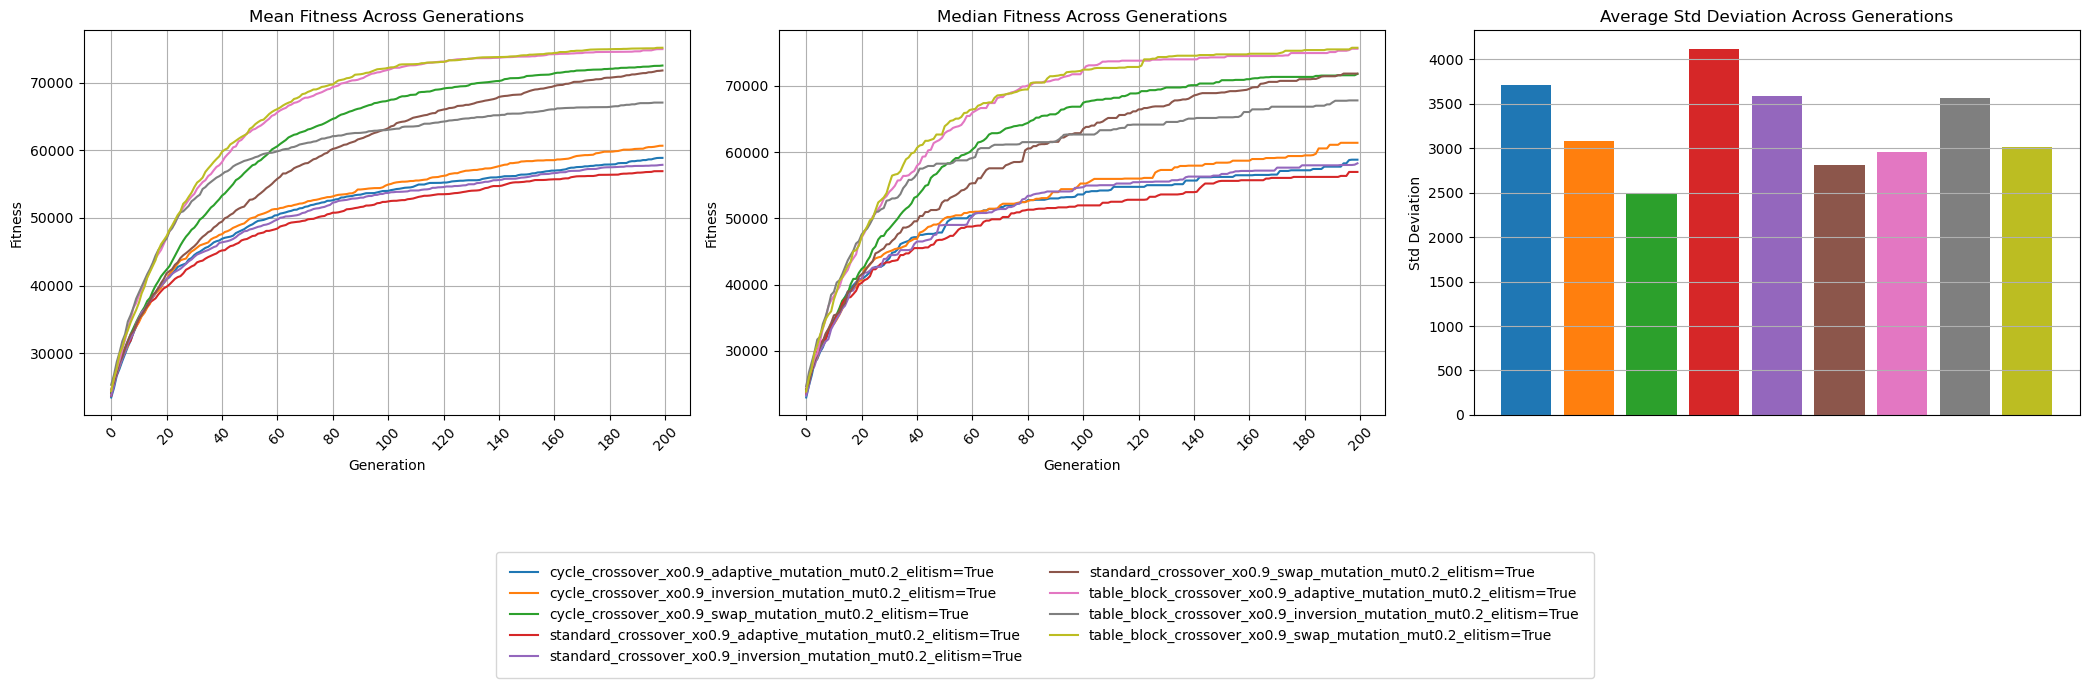

In [33]:
plot_fitness_over_gen(fitness_ts)

From this figure, we can see that the **`table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True`** and **`table_block_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True`** configurations consistently achieve the highest mean and median fitness across generations, indicating they are the best-performing setups among those tested.

While there are visible differences in average fitness levels, the **average standard deviation** across generations (rightmost plot) does not vary significantly between configurations. This suggests that **variability in performance is relatively consistent** and therefore **standard deviation will not be a key factor** in further comparisons.

In the following sections, we will explore the **statistical significance of the differences between the means** to determine whether these observed performance differences are meaningful.



**ABF for different configurations with Fitness Proportionate Selection**

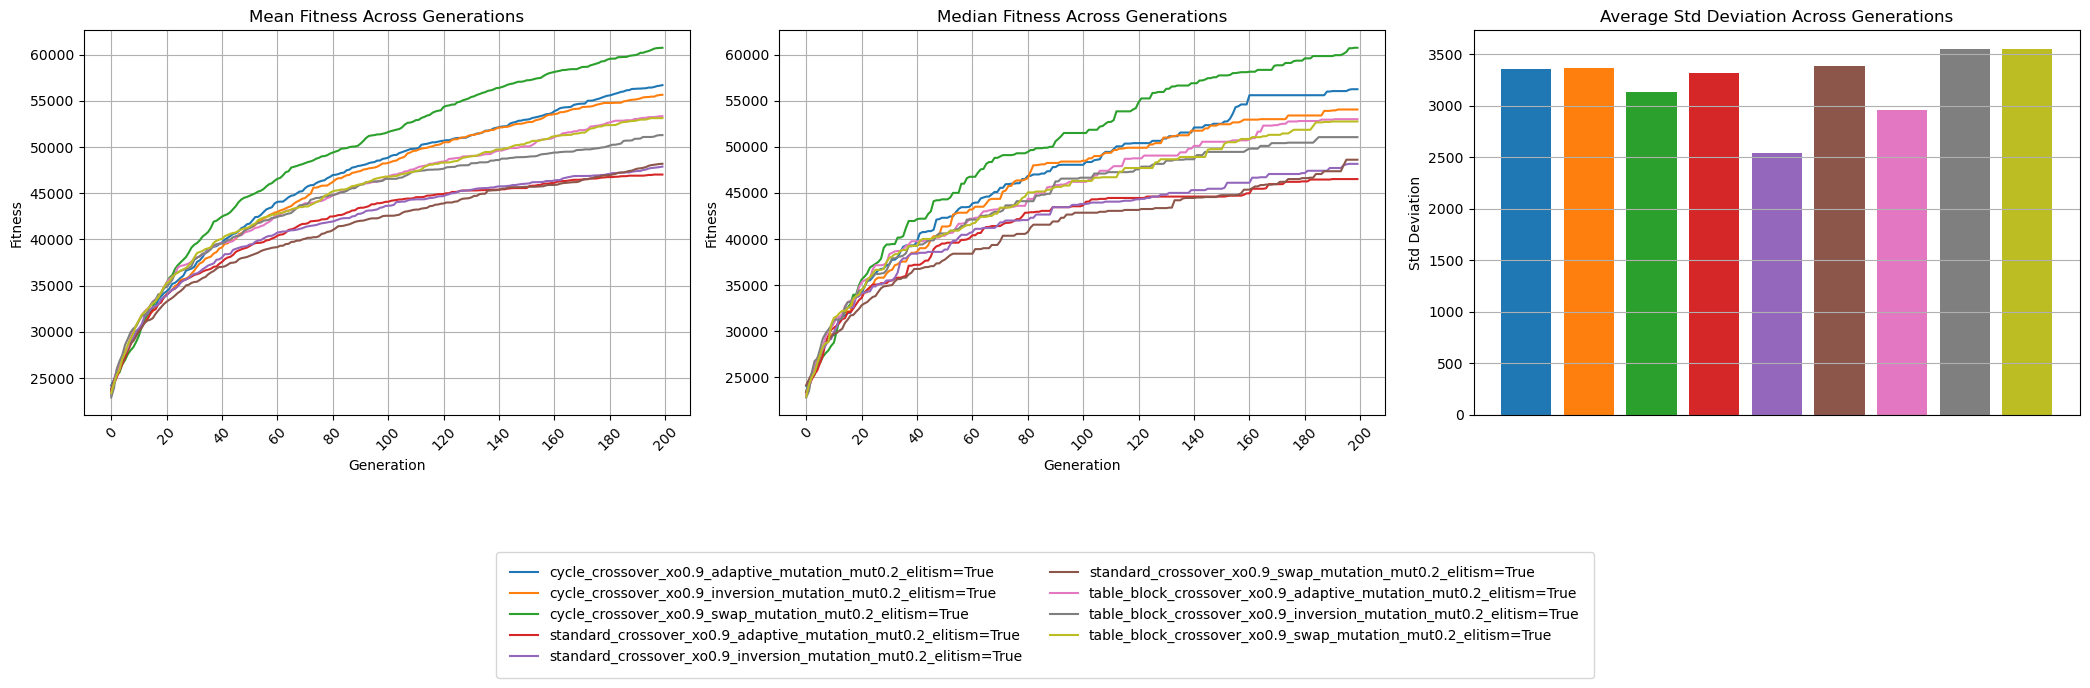

In [34]:
plot_fitness_over_gen(fitness_fps)

In this case, the **`cycle_crossover_xo0.9_swap_mutation_mut0.2_elitism=True`** configuration stands out clearly, achieving the highest mean and median fitness over generations, outperforming all other setups.

The standard deviations remain fairly consistent across configurations, similar to the previous results, and will again not be a focus in further analysis.


**ABF for different configurations with Ranking Selection**

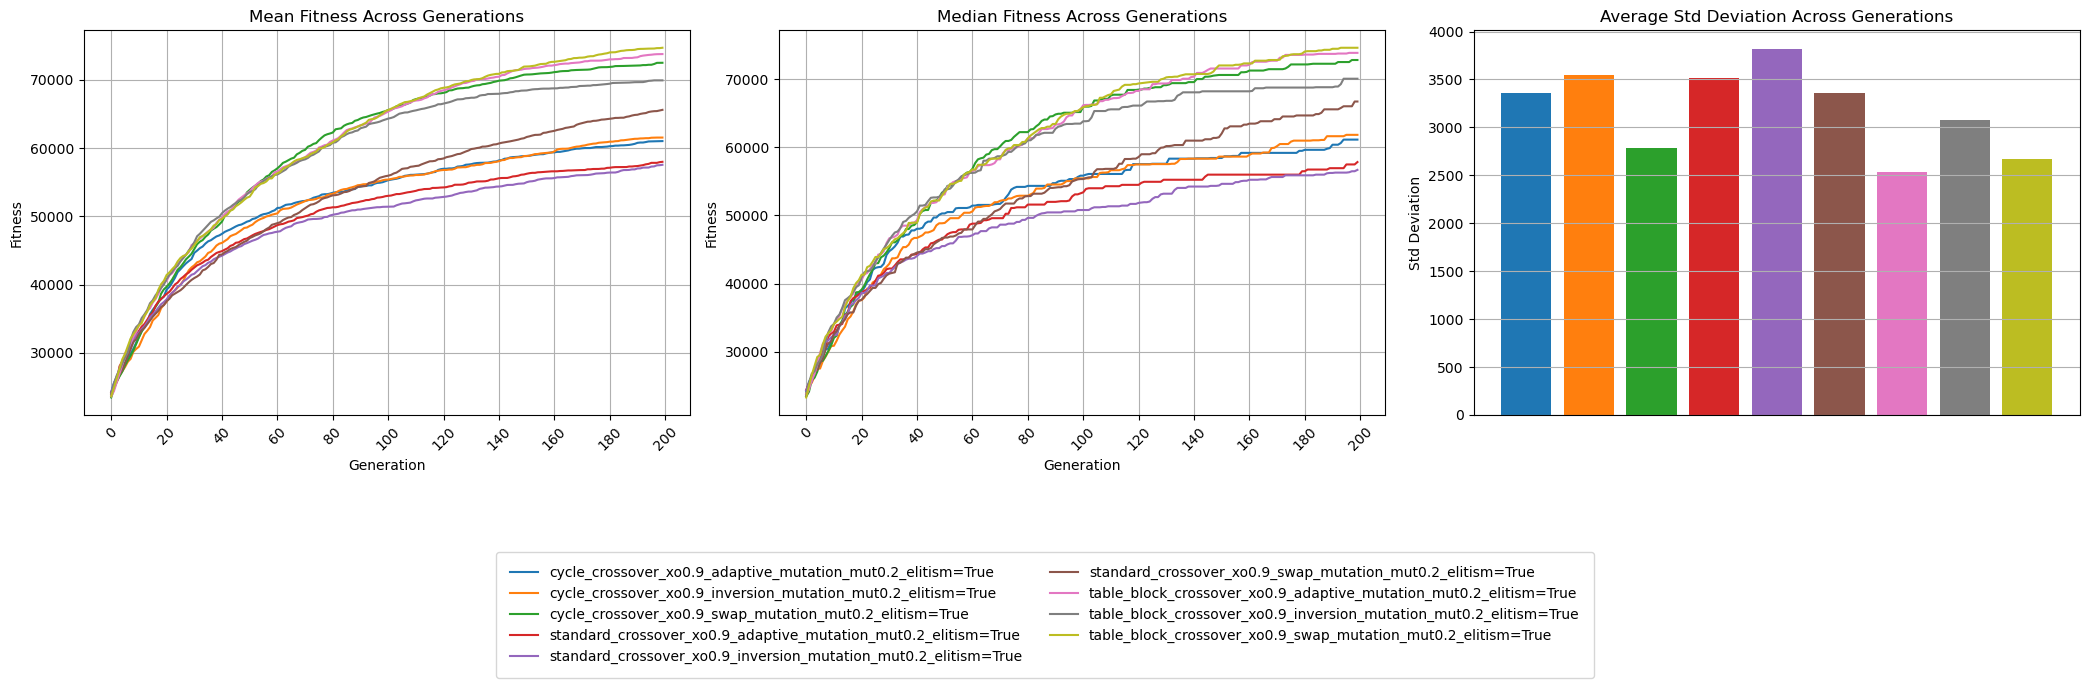

In [35]:
plot_fitness_over_gen(fitness_rs)

In this case, **`table_block_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True`** and **`table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True`** perform the best, reaching the highest mean and median fitness by the final generations.

As before, the **average standard deviations** across configurations are relatively close, so **variance will not be considered** in further analysis.


#### 2.4.2. Wilcoxon Rank-Sum Test

In this section we will see if the results obtained from each configuration are considered statistically signification within each of the selection types

In [36]:
def compare_fitness_until_significant(fitness_ts: dict, alpha: float = 0.05, maximize: bool = True):

    final_gen_means = {
        config: df.iloc[:, -1].mean()
        for config, df in fitness_ts.items()
    }

    sorted_configs = sorted(final_gen_means.items(), key=lambda x: x[1], reverse=maximize)

    best_label = sorted_configs[0][0]
    best_scores = fitness_ts[best_label].iloc[:, -1].values

    print(f"Best configuration: {best_label} (mean fitness = {final_gen_means[best_label]:.4f})\n")

    found_significant = False

    for i in range(1, len(sorted_configs)):
        compare_label = sorted_configs[i][0]
        compare_scores = fitness_ts[compare_label].iloc[:, -1].values

        stat, p_value = ranksums(best_scores, compare_scores)

        print(f"Wilcoxon Rank-Sum Test: {best_label} vs {compare_label}")
        print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

        if p_value < alpha:
            print("Statistically significant difference found (p < 0.05). Stopping here.\n")
            found_significant = True
            break
        else:
            print("No statistically significant difference (p ≥ 0.05). Continuing...\n")

    if not found_significant:
        print("No statistically significant difference found between the best and any of the others.")

**Willcoxon Rank-Sum test for different configurations with Tournament Selection**

In [37]:
compare_fitness_until_significant(fitness_ts, alpha=0.05, maximize=True)

Best configuration: table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True (mean fitness = 75153.3333)

Wilcoxon Rank-Sum Test: table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True vs table_block_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True
Statistic = 0.4879, p-value = 0.6256
No statistically significant difference (p ≥ 0.05). Continuing...

Wilcoxon Rank-Sum Test: table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True vs cycle_crossover_xo0.9_swap_mutation_mut0.2_elitism=True
Statistic = 3.7552, p-value = 0.0002
Statistically significant difference found (p < 0.05). Stopping here.



**Willcoxon Rank-Sum test for different configurations with Fitness Proportionate Selection**

In [38]:
compare_fitness_until_significant(fitness_fps, alpha=0.05, maximize=True)

Best configuration: cycle_crossover_xo0.9_swap_mutation_mut0.2_elitism=True (mean fitness = 60736.6667)

Wilcoxon Rank-Sum Test: cycle_crossover_xo0.9_swap_mutation_mut0.2_elitism=True vs cycle_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True
Statistic = 4.2210, p-value = 0.0000
Statistically significant difference found (p < 0.05). Stopping here.



**Willcoxon Rank-Sum test for different configurations with Ranking Selection**

In [39]:
compare_fitness_until_significant(fitness_rs, alpha=0.05, maximize=True)

Best configuration: table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True (mean fitness = 74680.0000)

Wilcoxon Rank-Sum Test: table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True vs table_block_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True
Statistic = 1.3676, p-value = 0.1715
No statistically significant difference (p ≥ 0.05). Continuing...

Wilcoxon Rank-Sum Test: table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True vs cycle_crossover_xo0.9_swap_mutation_mut0.2_elitism=True
Statistic = 3.3413, p-value = 0.0008
Statistically significant difference found (p < 0.05). Stopping here.



#### 2.4.3. Best configurations

From the previous section, we identified the top-performing configurations, including those that were not statistically significantly different from the best within each selection algorithm.
These five configurations were selected and stored, and since no statistically significant differences were found between them, they will now be evaluated together in a single comparison plot.

In [40]:
final_selected_configs = {
    "TS - Config 1": fitness_ts["table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True"], # best fitness
    "TS - Config 2": fitness_ts["table_block_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True"],
    "FPS - Config 3": fitness_fps["cycle_crossover_xo0.9_swap_mutation_mut0.2_elitism=True"],
    "RS - Config 4": fitness_rs["table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True"],
    "RS - Config 5": fitness_rs["table_block_crossover_xo0.9_adaptive_mutation_mut0.2_elitism=True"],}

**ABF test for the best configurations from the different selection algorithms**

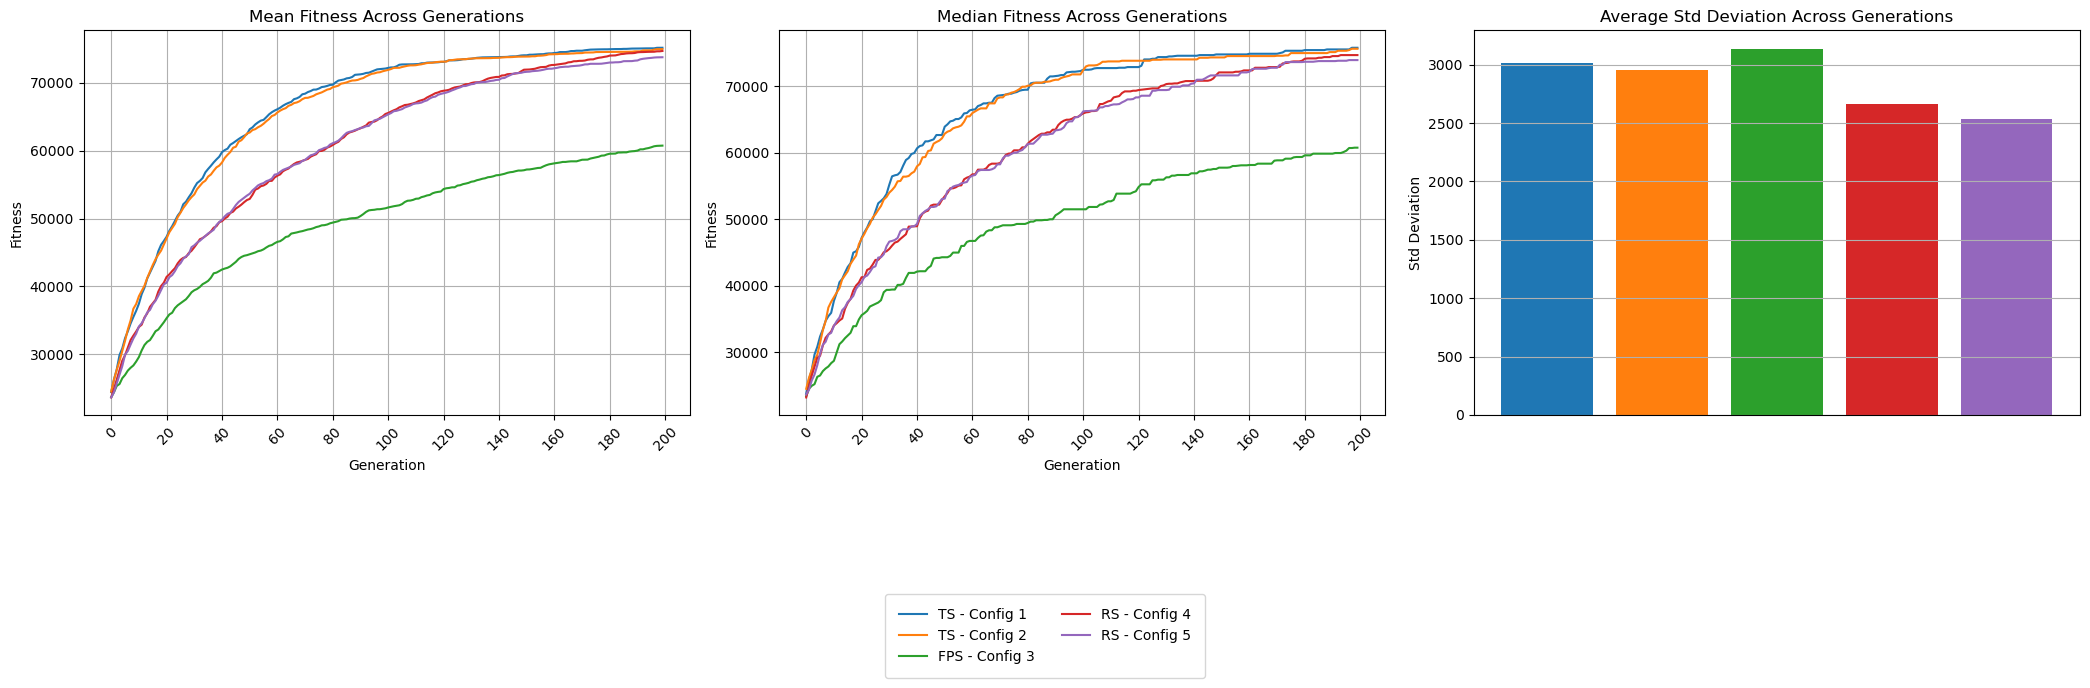

In [41]:
plot_fitness_over_gen(final_selected_configs)

**Willcoxon Rank-Sum test for the best configurations from the different selection algorithms**

In [42]:
compare_fitness_until_significant(final_selected_configs, alpha=0.05, maximize=True)

Best configuration: TS - Config 1 (mean fitness = 75153.3333)

Wilcoxon Rank-Sum Test: TS - Config 1 vs TS - Config 2
Statistic = 0.4879, p-value = 0.6256
No statistically significant difference (p ≥ 0.05). Continuing...

Wilcoxon Rank-Sum Test: TS - Config 1 vs RS - Config 4
Statistic = 1.3750, p-value = 0.1691
No statistically significant difference (p ≥ 0.05). Continuing...

Wilcoxon Rank-Sum Test: TS - Config 1 vs RS - Config 5
Statistic = 2.5429, p-value = 0.0110
Statistically significant difference found (p < 0.05). Stopping here.



Among the top five configurations, statistical analysis using the Wilcoxon Rank-Sum Test indicated that TS - Config 1, TS - Config 2, and RS - Config 4 are the best and do not differ significantly in terms of mean fitness (p ≥ 0.05). 

The standard deviation across generations for these configurations is also relatively close, so it won't be a measure for decision. 

Given these results, and the absence of statistically significant differences among the top contenders, it will be investigated the configuration that was able to get the **maximum fitness score**.


In [43]:
all_dfs = [pd.read_csv(f).assign(source=f) for f in files]
df = pd.concat(all_dfs, ignore_index=True)

fitness_cols = [c for c in df.columns if c not in ["config", "run", "source"]]
best_fitness = df[fitness_cols].max().max()

mask_best = df[fitness_cols] == best_fitness
configs_with_best = df[mask_best.any(axis=1)]["config"].unique()
print("Configs with best fitness overall:", configs_with_best)

Configs with best fitness overall: ['table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True']



From this we TS - Config 1 is selected as the best configuration, table_block_crossover_xo0.9_swap_mutation_mut0.2_elitism=True since it combines the best observed fitness with consistent results. 
Therefore be used as the baseline for Bayesian search to fine-tune the hyperparameters.

<a class="anchor" id="nine-bullet">
<d style="color:white;">

## 2.5. Bayesian Search of best model's parameters
</a>
</d>  

After identifying the best configuration, a Bayesian Search is performed to optimize key hyperparameters and enhance performance

In [ ]:
# def run_config_bo(xo_prob, mut_prob, k):
#     k = int(round(k))  # Because k must be an integer
#     print(f"\nTesting config: xo_prob={xo_prob:.2f}, mut_prob={mut_prob:.2f}, k={k}")
#     final_fitnesses = []

#     for run in range(RUNS):
#         print(f"  - Run {run + 1}/{RUNS}")
#         population = [
#             GASolution(
#                 crossover_fn=table_block_crossover,
#                 mutation_fn=swap_mutation,
#                 guests=guests,
#                 initialization_type="random"
#             ) for _ in range(POP_SIZE)
#         ]

#         selection_fn = lambda pop: tournament_selection(pop, k)

#         best_solution, _ = genetic_algorithm(
#             initial_population=population,
#             max_gen=GENERATIONS,
#             selection_algorithm=selection_fn,
#             xo_prob=xo_prob,
#             mut_prob=mut_prob,
#             elitism=True,
#             verbose=False
#         )
#         final_fitnesses.append(best_solution.fitness())

#     avg_fitness = np.mean(final_fitnesses)
#     print(f" --> Mean Fitness: {avg_fitness:.2f}")
#     return avg_fitness

# # Define search space
# pbounds = {
#     "xo_prob": (0.6, 0.9),
#     "mut_prob": (0.1, 0.4),
#     "k": (2, 4)
# }

# optimizer = BayesianOptimization(
#     f=run_config_bo,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# # Start optimization (can adjust init_points and n_iter)
# optimizer.maximize(
#     init_points=5,
#     n_iter=15
# )

# print("\nBest configuration found:")
# print(optimizer.max)

# # Output:
# # params': {'k': 3, 'mut_prob': 0.4, 'xo_prob': 0.9 }

In [45]:
# # For visualization purposes
# results_table = []

# for i, res in enumerate(optimizer.res):
#     params = res["params"]
#     target = res["target"]
#     results_table.append({
#         "iter": i + 1,
#         "k": int(round(params["k"])),
#         "mut_prob": round(params["mut_prob"], 3),
#         "xo_prob": round(params["xo_prob"], 3),
#         "average_fitness": round(target, 2),
#     })
# df_results = pd.DataFrame(results_table)
# df_results = df_results.sort_values(by="average_fitness", ascending=False)
# df_results.reset_index(drop=True, inplace=True)
# print(df_results.to_string(index=False))

# Output:
#  iter  k  mut_prob  xo_prob  average_fitness
#     9  3     0.400    0.900         76200.00
#    12  3     0.400    0.783         75903.33
#    11  3     0.315    0.899         75713.33
#     6  3     0.400    0.900         75356.67
#    13  3     0.398    0.607         75280.00
#    16  3     0.358    0.628         75263.33
#    17  4     0.400    0.600         75196.67
#    20  3     0.316    0.638         75186.67
#    14  4     0.400    0.900         75026.67
#     1  3     0.385    0.820         75006.67
#     8  3     0.400    0.820         74906.67
#    10  3     0.400    0.900         74876.67
#     5  4     0.164    0.655         74363.33
#    19  3     0.118    0.727         73916.67
#     7  3     0.206    0.900         73853.33
#     2  3     0.147    0.647         73780.00
#     4  3     0.106    0.891         73700.00
#    18  3     0.177    0.751         73680.00
#     3  2     0.360    0.780         73560.00
#    15  4     0.100    0.900         73283.33

#### 2.5.1.  Solution

From the previous code we conclude the best solution has the following parameters: k=3, mut_prob=0.4, xo_prob=0.9

In [ ]:
NUM_RUNS = 30
final_solution = None
BEST_GLOBAL_FITNESS = -np.inf  # ou float('-inf')

for run in range(NUM_RUNS):
    print(f"\n--- Run {run+1}/{NUM_RUNS} ---")

    initial_population = [
        GASolution(
            crossover_fn=table_block_crossover,
            mutation_fn=swap_mutation,
            guests=guests,
            initialization_type="random"
        ) for _ in range(100)
    ]

    best_solution, _ = genetic_algorithm(
        initial_population=initial_population,
        max_gen=300,
        selection_algorithm=lambda pop: tournament_selection(pop, k=3),
        xo_prob=0.9,
        mut_prob=0.4,
        elitism=True,
        verbose=False)

    fitness = best_solution.fitness()
    print(f"Run {run+1} fitness: {fitness:.2f}")

    if fitness > BEST_GLOBAL_FITNESS:
        BEST_GLOBAL_FITNESS = fitness
        final_solution = best_solution

print(f"\n Best overall fitness after {NUM_RUNS} runs: {BEST_GLOBAL_FITNESS:.2f}")


--- Run 1/30 ---
Run 1 fitness: 74400.00

--- Run 2/30 ---
Run 2 fitness: 75100.00

--- Run 3/30 ---
Run 3 fitness: 78500.00

--- Run 4/30 ---
Run 4 fitness: 77900.00

--- Run 5/30 ---
Run 5 fitness: 73300.00

--- Run 6/30 ---
Run 6 fitness: 76000.00

--- Run 7/30 ---
Run 7 fitness: 74400.00

--- Run 8/30 ---
Run 8 fitness: 80800.00

--- Run 9/30 ---
Run 9 fitness: 69300.00

--- Run 10/30 ---
Run 10 fitness: 78600.00

--- Run 11/30 ---
Run 11 fitness: 76000.00

--- Run 12/30 ---
Run 12 fitness: 77100.00

--- Run 13/30 ---
Run 13 fitness: 76600.00

--- Run 14/30 ---
Run 14 fitness: 78200.00

--- Run 15/30 ---
Run 15 fitness: 75300.00

--- Run 16/30 ---
Run 16 fitness: 78300.00

--- Run 17/30 ---
Run 17 fitness: 72500.00

--- Run 18/30 ---
Run 18 fitness: 70500.00

--- Run 19/30 ---
Run 19 fitness: 70300.00

--- Run 20/30 ---
Run 20 fitness: 79200.00

--- Run 21/30 ---
Run 21 fitness: 76000.00

--- Run 22/30 ---
Run 22 fitness: 72600.00

--- Run 23/30 ---
Run 23 fitness: 75800.00

--- R

In [55]:
pickle.dump(final_solution, open("final_solution.pkl", 'wb')) # best allocation of 80800 saved in a pickle

In [56]:
final_solution = pickle.load(open("final_solution.pkl", 'rb'))
print('The best fitness obtained is ', final_solution.fitness(), 'this solution is saved in a pickle that is loaded as \'final_solution\' ')

The best fitness obtained is  80800 this solution is saved in a pickle that is loaded as 'final_solution' 


#### 2.5.2. Visualization of the Final Best Solution

   For visualization purposes, we create a dataframe with the numbers of people to understand who is sat together

In [57]:

df_people = [(1, "groom", "groom"),
    (2, "bride", "bride"),
    (3, "bride", "father"),
    (4, "bride", "mother"),
    (5, "groom", "father"),
    (6, "groom", "mother"),
    (7, "groom", "aunt"),
    (8, "groom", "uncle"),
    (9, "groom", "cousin"),
    (10, "groom", "cousin"),
    (11, "bride", "uncle"),
    (12, "bride", "aunt"),
    (13, "groom", "uncle"),
    (14, "groom", "aunt"),
    (15, "groom", "cousin"),
    (16, "groom", "brother"),
    (17, "groom", "brother"),
    (18, "groom", "brother"),
    (19, "groom", "nephew"),
    (20, "groom", "sister_in_law"),
    (21, "groom", "niece2"),
    (22, "groom", "sister_in_law"),
    (23, "groom", "cousin"),
    (24, "groom", "uncle"),
    (25, "groom", "aunt"),
    (26, "groom", "uncle"),
    (27, "groom", "aunt"),
    (28, "groom", "cousin"),

    (29, "bride", "friend_college"),
    (30, "bride", "friend_college"),
    (31, "bride", "friend_college_son"),
    (32, "bride", "friend_college"),
    (33, "bride", "friend_college_date"),
    (34, "bride", "friend_college"),
    (35, "bride", "friend_college"),
    (36, "bride", "friend_college"),

    (37, "groom", "friend_college"),
    (38, "groom", "best_friend_college"),
    (44, "groom", "friend_college"),
    (50, "groom", "best_friend_college"),
    (60, "groom", "friend_college"),

    (39, "bride", "friend_hometown"),
    (40, "bride", "friend_hometown"),
    (41, "bride", "friend_hometown"),
    (42, "bride", "friend_hometown_son"),
    (43, "bride", "friend_hometown_son"),
    (45, "bride", "friend_hometown"),

    (51, "bride", "friend_work"),
    (52, "bride", "friend_work"),
    (53, "bride", "friend_work_son"),
    (54, "bride", "best_friend_work"),
    (55, "bride", "friend_work"),
    (56, "bride", "friend_work"),
    (57, "bride", "friend_work_date"),
    (58, "bride", "friend_work"),

    (59, "groom", "friend_work"),
    (61, "groom", "friend_work"),
    (62, "groom", "friend_work_date"),
    (63, "groom", "friend_work_son"),
    (64, "groom", "friend_work_son"),

    (46, "both", "friend_padel"),
    (47, "both", "friend_padel"),
    (48, "both", "friend_padel_date"),
    (49, "both", "friend_padel")]

df_people = pd.DataFrame(df_people, columns=["idx", "side", "relation"])
df_people = df_people.set_index('idx')

In [ ]:
print('\nThe best combination of people sitting is as follows:')
for i, table in enumerate(final_solution.representation, 1):
    print(f"\nTable {i}")
    for guest in table:
        guest_id = guest.guest_id
        if guest_id in df_people.index:
            side = df_people.loc[guest_id, 'side']
            relation = df_people.loc[guest_id, 'relation']
            print(f"- {guest_id}: {side} | {relation}")
        else:
            print(f"- {guest_id}: Not found in df_people")


The best combination of people sitting is as follows:

Table 1
- 34: bride | friend_college
- 57: bride | friend_work_date
- 58: bride | friend_work
- 29: bride | friend_college
- 30: bride | friend_college
- 31: bride | friend_college_son
- 37: groom | friend_college
- 60: groom | friend_college

Table 2
- 12: bride | aunt
- 45: bride | friend_hometown
- 11: bride | uncle
- 14: groom | aunt
- 3: bride | father
- 13: groom | uncle
- 4: bride | mother
- 15: groom | cousin

Table 3
- 48: both | friend_padel_date
- 51: bride | friend_work
- 59: groom | friend_work
- 52: bride | friend_work
- 53: bride | friend_work_son
- 46: both | friend_padel
- 49: both | friend_padel
- 47: both | friend_padel

Table 4
- 25: groom | aunt
- 19: groom | nephew
- 23: groom | cousin
- 17: groom | brother
- 21: groom | niece2
- 20: groom | sister_in_law
- 5: groom | father
- 24: groom | uncle

Table 5
- 41: bride | friend_hometown
- 10: groom | cousin
- 42: bride | friend_hometown_son
- 43: bride | friend_h

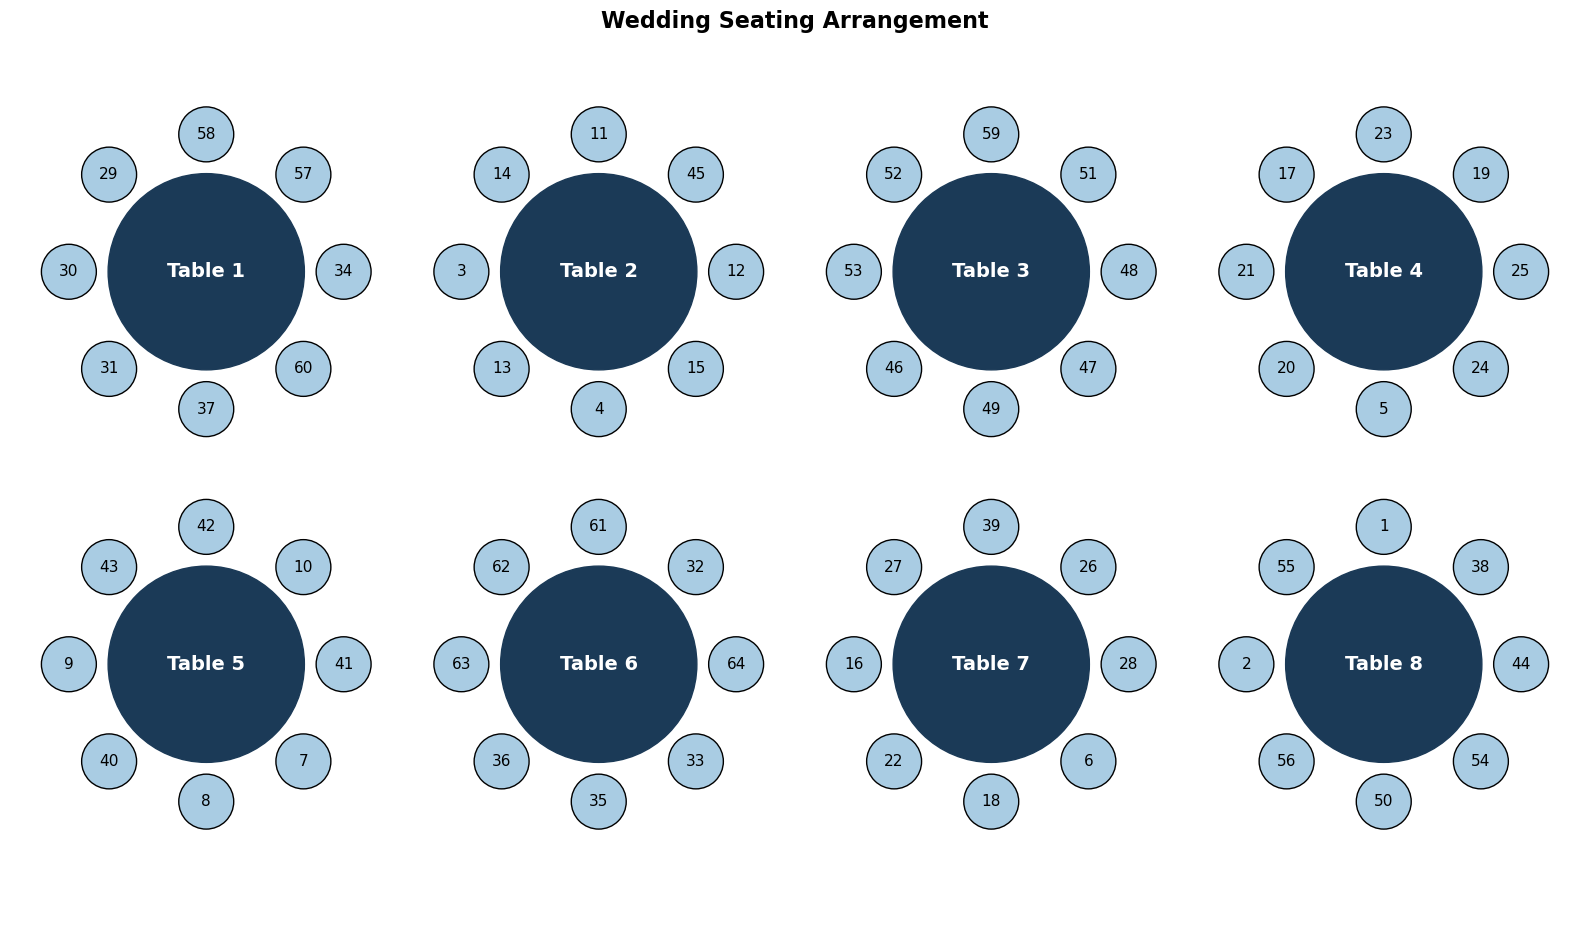

In [ ]:
def plot_seating_arrangement(solution, df_people):
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(-20, 20)
    ax.set_ylim(-5, 18)
    ax.set_aspect('equal')
    ax.axis('off')
    
    num_tables = len(solution.representation)
    guests_per_table = len(solution.representation[0])
    
    table_positions = [(x, y) for y in [12, 2] for x in [-15, -5, 5, 15]]
    
    for i, (table, pos) in enumerate(zip(solution.representation, table_positions), 1):
        x_center, y_center = pos
        radius = 2.5  
        chair_radius = 3.5  

        table_circle = plt.Circle((x_center, y_center), radius, color='#1B3A57', zorder=1)
        ax.add_patch(table_circle)
        
        ax.text(x_center, y_center, f"Table {i}", ha='center', va='center', color='white', fontsize=14, weight='bold', zorder=2)

        angle_step = 2 * np.pi / guests_per_table
        for j, guest in enumerate(table):
            angle = j * angle_step
            chair_x = x_center + chair_radius * np.cos(angle)
            chair_y = y_center + chair_radius * np.sin(angle)
            
            guest_id = guest.guest_id
            
            chair = plt.Circle((chair_x, chair_y), 0.7, color='#A9CCE3', ec='black', zorder=3)
            ax.add_patch(chair)
            
            ax.text(chair_x, chair_y, str(guest_id), ha='center', va='center', fontsize=11, zorder=4)

    plt.title("Wedding Seating Arrangement", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

plot_seating_arrangement(final_solution, df_people)

In [60]:
# Check if the solution is valid
validate_seating_solution(final_solution.representation)

Valid seating solution


<hr>
<a class="anchor" id="ten-bullet">
<d style="color:white;">

# 3. GA vs Other Optimization Techniques
</a>
</d>   

In [ ]:
class TableSASolution(BaseGASolution):
    def get_random_neighbor(self):
        neighbor = deepcopy(self)

        # Select two different tables
        t1, t2 = random.sample(range(self.num_tables), 2)

        # Select a random guest from each table
        g1 = random.choice(neighbor.representation[t1])
        g2 = random.choice(neighbor.representation[t2])

        # Swap the guests between the two tables
        i1 = neighbor.representation[t1].index(g1)
        i2 = neighbor.representation[t2].index(g2)

        neighbor.representation[t1][i1], neighbor.representation[t2][i2] = g2, g1

        return neighbor

<a class="anchor" id="eleven-bullet">
<d style="color:white;">

## 3.1. Hill Climbing
</a>
</d>  

In [ ]:
def hill_climbing(
    initial_solution,
    max_iter: int = 100,
    verbose: bool = False
):
    current_solution = initial_solution
    iter = 1

    if verbose:
        print(f'Initial solution fitness: {current_solution.fitness()}')

    while iter <= max_iter:
        neighbor = current_solution.get_random_neighbor()
        neighbor_fitness = neighbor.fitness()
        current_fitness = current_solution.fitness()

        if verbose:
            print(f"Iteration {iter} - Current Fitness: {current_fitness:.2f} | Neighbor Fitness: {neighbor_fitness:.2f}")

        if neighbor_fitness > current_fitness:
            current_solution = deepcopy(neighbor)
            if verbose:
                print("Accepted better neighbor.\n")
        else:
            if verbose:
                print("No better neighbor found. Stopping.\n")
            break  # No improvement → Local optimum reached

        iter += 1

    return current_solution

In [ ]:
initial_solution = TableSASolution(guests=guests, initialization_type='random')

best_hc_solution = hill_climbing(initial_solution, max_iter=100, verbose=True)

print("Best solution fitness from Hill Climbing:", best_hc_solution.fitness())

Initial solution fitness: 9700
Iteration 1 - Current Fitness: 9700.00 | Neighbor Fitness: 8600.00
No better neighbor found. Stopping.

Best solution fitness from Hill Climbing: 9700


<a class="anchor" id="twelve-bullet">
<d style="color:white;">

## 3.2. Simulated Annealing
</a>
</d>  

We decided to implement Simulated Annealing to help escape local optima and increase the chances of reaching a global optimum. Simulated Annealing extend the possibility of worsening the fitness of the current solution, avoiding getting stuck in suboptimal configurations.

In [ ]:
def simulated_annealing(
    initial_solution,
    C: float = 100,
    L: int = 10,
    H: float = 1.1,
    max_iter: int = 10,
    verbose: bool = False):

    current_solution = initial_solution
    iter = 1

    if verbose:
        print(f'Initial solution fitness: {current_solution.fitness()}')

    while iter <= max_iter:
        for _ in range(L):
            neighbor = current_solution.get_random_neighbor()
            neighbor_fitness = neighbor.fitness()
            current_fitness = current_solution.fitness()

            if verbose:
                print(f"Neighbor fitness: {neighbor_fitness}")

            if neighbor_fitness >= current_fitness:
                current_solution = deepcopy(neighbor)
                if verbose: print("Accepted better neighbor.")
            else:
                prob = np.exp(-abs(current_fitness - neighbor_fitness) / C)
                if random.random() < prob:
                    current_solution = deepcopy(neighbor)
                    if verbose: print("Accepted worse neighbor probabilistically.")
                else:
                    if verbose: print("Rejected worse neighbor.")

        C /= H
        iter += 1
        if verbose: print(f'Cooling down: new C = {C}\n')

    return current_solution

In [ ]:
def simulated_annealing(
    initial_solution,
    C: float = 100,
    L: int = 10,
    H: float = 1.1,
    max_iter: int = 10,
    verbose: bool = False,
    text: bool = True 
):
    current_solution = initial_solution
    iter = 1

    def log(msg):
        if text and verbose:
            print(msg)

    if verbose:
        log(f'Initial solution fitness: {current_solution.fitness()}')

    while iter <= max_iter:
        for _ in range(L):
            neighbor = current_solution.get_random_neighbor()
            neighbor_fitness = neighbor.fitness()
            current_fitness = current_solution.fitness()

            log(f"Neighbor fitness: {neighbor_fitness}")

            if neighbor_fitness >= current_fitness:
                current_solution = deepcopy(neighbor)
                log("Accepted better neighbor.")
            else:
                prob = np.exp(-abs(current_fitness - neighbor_fitness) / C)
                if random.random() < prob:
                    current_solution = deepcopy(neighbor)
                    log("Accepted worse neighbor probabilistically.")
                else:
                    log("Rejected worse neighbor.")

        C /= H
        iter += 1
        log(f'Cooling down: new C = {C}\n')

    return current_solution

In [ ]:
initial_solution = TableSASolution(guests=guests, initialization_type='random')

best_sa_solution = simulated_annealing(initial_solution, max_iter=100, verbose=True)

print("Best solution fitness from SA:", best_sa_solution.fitness())

Initial solution fitness: 13600
Neighbor fitness: 12900
Rejected worse neighbor.
Neighbor fitness: 11700
Rejected worse neighbor.
Neighbor fitness: 13000
Rejected worse neighbor.
Neighbor fitness: 13700
Accepted better neighbor.
Neighbor fitness: 15100
Accepted better neighbor.
Neighbor fitness: 15100
Accepted better neighbor.
Neighbor fitness: 13900
Rejected worse neighbor.
Neighbor fitness: 17000
Accepted better neighbor.
Neighbor fitness: 14900
Rejected worse neighbor.
Neighbor fitness: 16200
Rejected worse neighbor.
Cooling down: new C = 90.9090909090909

Neighbor fitness: 17800
Accepted better neighbor.
Neighbor fitness: 18200
Accepted better neighbor.
Neighbor fitness: 17500
Rejected worse neighbor.
Neighbor fitness: 18400
Accepted better neighbor.
Neighbor fitness: 16000
Rejected worse neighbor.
Neighbor fitness: 18300
Rejected worse neighbor.
Neighbor fitness: 19100
Accepted better neighbor.
Neighbor fitness: 17300
Rejected worse neighbor.
Neighbor fitness: 19100
Accepted bette

Accepted better neighbor.
Neighbor fitness: 45400
Accepted better neighbor.
Neighbor fitness: 44300
Rejected worse neighbor.
Neighbor fitness: 43300
Rejected worse neighbor.
Cooling down: new C = 19.784466890013498

Neighbor fitness: 42100
Rejected worse neighbor.
Neighbor fitness: 42300
Rejected worse neighbor.
Neighbor fitness: 45400
Accepted better neighbor.
Neighbor fitness: 40700
Rejected worse neighbor.
Neighbor fitness: 42600
Rejected worse neighbor.
Neighbor fitness: 41400
Rejected worse neighbor.
Neighbor fitness: 42100
Rejected worse neighbor.
Neighbor fitness: 44100
Rejected worse neighbor.
Neighbor fitness: 47400
Accepted better neighbor.
Neighbor fitness: 43100
Rejected worse neighbor.
Cooling down: new C = 17.98587899092136

Neighbor fitness: 43600
Rejected worse neighbor.
Neighbor fitness: 45500
Rejected worse neighbor.
Neighbor fitness: 44500
Rejected worse neighbor.
Neighbor fitness: 45400
Rejected worse neighbor.
Neighbor fitness: 44900
Rejected worse neighbor.
Neighb

<a class="anchor" id="thirteen-bullet">
<d style="color:white;">

## 3.3. Comparison
</a>
</d>  


Run 1/30
HC fitness: 5100.00
SA fitness: 66800.00
GA fitness: 71700.00

Run 2/30
HC fitness: 16100.00
SA fitness: 63700.00
GA fitness: 78900.00

Run 3/30
HC fitness: 7500.00
SA fitness: 64400.00
GA fitness: 77600.00

Run 4/30
HC fitness: 9200.00
SA fitness: 65100.00
GA fitness: 72800.00

Run 5/30
HC fitness: 14500.00
SA fitness: 64900.00
GA fitness: 76700.00

Run 6/30
HC fitness: 15900.00
SA fitness: 66900.00
GA fitness: 78400.00

Run 7/30
HC fitness: 12400.00
SA fitness: 66900.00
GA fitness: 77200.00

Run 8/30
HC fitness: 6900.00
SA fitness: 72000.00
GA fitness: 71700.00

Run 9/30
HC fitness: 18400.00
SA fitness: 65100.00
GA fitness: 71100.00

Run 10/30
HC fitness: 6800.00
SA fitness: 67500.00
GA fitness: 79300.00

Run 11/30
HC fitness: 16200.00
SA fitness: 68300.00
GA fitness: 76100.00

Run 12/30
HC fitness: 9400.00
SA fitness: 67500.00
GA fitness: 77600.00

Run 13/30
HC fitness: 14600.00
SA fitness: 70000.00
GA fitness: 75800.00

Run 14/30
HC fitness: 9500.00
SA fitness: 69700.00
G

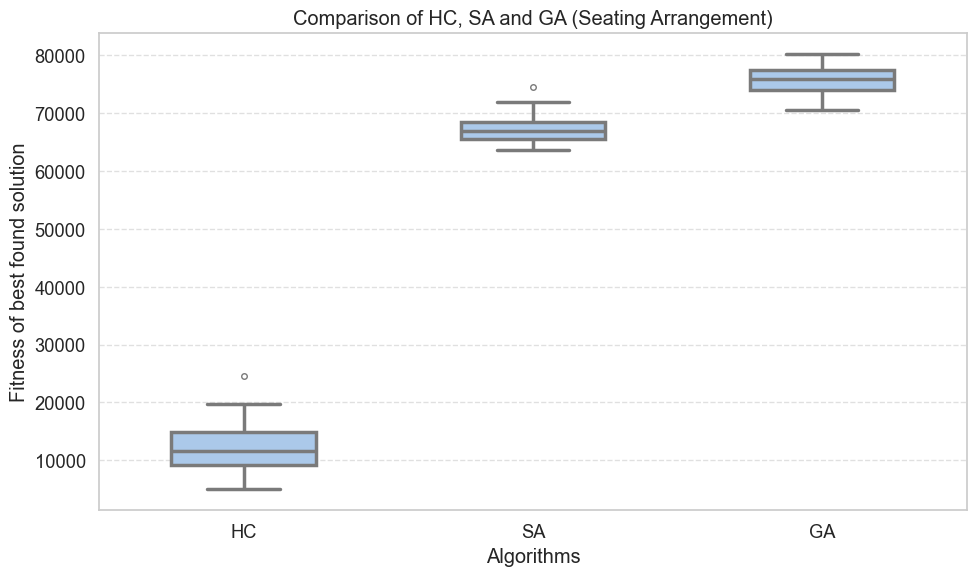

In [ ]:
hc_best_fitnesses = []
sa_best_fitnesses = []
ga_best_fitnesses = []

for run_nr in range(RUNS):
    print(f"\nRun {run_nr + 1}/{RUNS}")

    ### HILL CLIMBING ###
    hc_initial = TableSASolution(guests=guests, initialization_type='random')
    best_hc_solution = hill_climbing(hc_initial, max_iter=100, verbose=False)
    hc_best_fitnesses.append(best_hc_solution.fitness())
    print(f"HC fitness: {best_hc_solution.fitness():.2f}")

    ### SIMULATED ANNEALING ###
    initial_solution = TableSASolution(guests=guests, initialization_type='random')
    best_sa_solution = simulated_annealing(initial_solution, max_iter=100, verbose=True, text=False)

    sa_best_fitnesses.append(best_sa_solution.fitness())
    print(f"SA fitness: {best_sa_solution.fitness():.2f}")

    ### GENETIC ALGORITHM ###
    ga_population = [
        GASolution(
            crossover_fn=table_block_crossover,
            mutation_fn=swap_mutation,
            guests=guests,
            initialization_type="random"
        )
        for _ in range(POP_SIZE)
    ]

    best_ga_solution, _ = genetic_algorithm(
        initial_population=ga_population,
        max_gen=200,
        selection_algorithm=tournament_selection,
        xo_prob=0.9,
        mut_prob=0.4,
        elitism=True,
        verbose=False
    )

    ga_best_fitnesses.append(best_ga_solution.fitness())
    print(f"GA fitness: {best_ga_solution.fitness():.2f}")

df = pd.DataFrame({
    'value': hc_best_fitnesses + sa_best_fitnesses + ga_best_fitnesses,
    'group': ['HC'] * RUNS + ['SA'] * RUNS + ['GA'] * RUNS
})

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='value', data=df, width=0.5, linewidth=2.5, fliersize=4)

plt.title('Comparison of HC, SA and GA (Seating Arrangement)')
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found solution')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
average_HC = np.mean(hc_best_fitnesses)
average_SA = np.mean(sa_best_fitnesses)
average_GA = np.mean(ga_best_fitnesses)

print(f"\nFitness average after {RUNS} executions:")
print(f"HC: {average_HC:.2f}")
print(f"SA: {average_SA:.2f}")
print(f"GA: {average_GA:.2f}")


Fitness average after 30 executions:
HC: 12383.33
SA: 67273.33
GA: 75616.67


As expected, the Genetic Algorithm works better than Hill Climbing or Simulated Annealing for this problem.
This is because:

- In Hill Climbing: the algorithm gets stuck quickly in local optima since it only accepts improvements from neighboring solutions. With such a huge space of seating arrangements, it struggled to explore enough diverse solutions.

- In Simulated Annealing: performs better since it sometimes accepting worse solutions, escaping local optimas. However, it still didn’t quite match the quality of the Genetic Algorithm.

The Genetic Algorithm’s use of a population and genetic operators allows better exploration of seating combinations, consistently finding higher overall guest happiness under the problem’s constraints.